# Assignment 4: Quantum Channel Classification
We reuse the Week 3 classifier to tag noisy channels quickly during calibration checks.

This week we focus on applying the saved classifier and showing that the workflow runs end to end.

**Task plan**
1. Explain why quick channel labels matter and list the workflow you will follow.
2. Load the helper code, pull in the trained estimator, and note any backup plan.
3. Rebuild the feature mapper from Kraus operators to Choi vectors.
4. Test the model on a small batch of synthetic channels and record observations.

## Background notes
- A quantum channel $\mathcal{E}$ is a completely positive, trace-preserving map. We write $\mathcal{E}(\rho) = \sum_k K_k \rho K_k^\dagger$ with $\sum_k K_k^\dagger K_k = I$ so that each Kraus operator $K_k$ captures one noise branch.
- The Choi matrix $C_{\mathcal{E}} = (\mathcal{E} \otimes I)(|\Phi^+\rangle\langle\Phi^+|)$ models how the channel acts on half of an entangled pair. Flattening its real and imaginary parts gives a steady feature vector.
- Classification is lighter than full tomography. We only emit labels like depolarising or amplitude damping, which keeps the calibration loop fast.

In [1]:
!git clone https://github.com/ansul1214/Open_Project_Winter_2025.git

Cloning into 'Open_Project_Winter_2025'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 301 (delta 38), reused 12 (delta 12), pack-reused 231 (from 3)
Receiving objects: 100% (301/301), 1.17 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (126/126), done.


## Task 1 · Environment check
- Confirm qiskit, numpy, pandas, joblib, and scikit-learn import without errors.
- If anything is missing, run the pip cell below and log the command in your notes.
- Once the imports work, move to Task 2.

In [2]:
# Log your environment status here once Task 1 is complete.
required_packages = [
    "qiskit",
    "numpy",
    "pandas",
    "joblib",
    "sklearn"
]

missing = []

for pkg in required_packages:
    try:
        __import__(pkg)
        print(f"{pkg} imported successfully.")
    except ImportError:
        print(f"{pkg} NOT installed.")
        missing.append(pkg)

if missing:
    print("\nMissing packages detected:", missing)
else:
    print("\nAll required packages imported successfully.")


qiskit NOT installed.
numpy imported successfully.
pandas imported successfully.
joblib imported successfully.
sklearn imported successfully.

Missing packages detected: ['qiskit']


In [3]:
# Install prerequisites if the kernel is missing a package.
# !pip install qiskit scikit-learn joblib pandas
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00


## Task 2 · Import helper modules
- Run the cell below to pull in numpy, joblib, qiskit, pandas, and os.
- Keep the imports in one place so later tasks stay consistent.

In [4]:
import numpy as np
import joblib
from sklearn.dummy import DummyClassifier
from qiskit.quantum_info import Kraus, Choi
import pandas as pd
import os


In [5]:
%cd Open_Project_Winter_2025

/content/Open_Project_Winter_2025


In [6]:
#Load trained classifier from Assignment_3
import numpy as np
import joblib
import os
from qiskit.quantum_info import Kraus, Choi

model_path = "Assignment_3/channel_classifier.pkl"

print("Checking model path:", model_path)
print("File exists:", os.path.exists(model_path))

try:
    model = joblib.load(model_path)
    print("\nModel loaded successfully.")
    print("Model type:", type(model))
    print("Expected input features:", model.n_features_in_)
    print("Classes:", model.classes_)
except Exception as e:
    print("Model loading failed:", e)
    model = None

Checking model path: Assignment_3/channel_classifier.pkl
File exists: True

Model loaded successfully.
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Expected input features: 32
Classes: ['amplitude_damping' 'depolarizing']


## Task 3 · Build a calibration-time classifier
- Implement a lightweight classifier that maps Choi features to channel labels without relying on saved artefacts.
- Keep the training code inside the provided function so reviewers can see your modelling choices.
- You may reuse utilities from earlier assignments (data loaders, feature encoders) as long as they are imported inside the function.

In [ ]:
def build_channel_classifier():
    """
    TODO: Train and return a classifier that distinguishes the channel families used in this exercise.

    Suggested steps:
        1. Create or load a labelled dataset of Choi features (can reuse helpers from Assignment 3).
        2. Split into train/validation sets to tune hyperparameters if needed.
        3. Fit a simple baseline model (e.g., logistic regression, random forest) and report key metrics via prints.
        4. Return the trained estimator so downstream cells can call `predict`.
    """
    raise NotImplementedError("Implement the calibration-time classifier for Task 3.")

model = build_channel_classifier()

In [7]:
def build_channel_classifier():

    import numpy as np
    from qiskit.quantum_info import Kraus, Choi
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report
    # Channel definitions

    def depolarizing_kraus(p):
        k0 = np.sqrt(1 - 3*p/4) * np.eye(2)
        k1 = np.sqrt(p/4) * np.array([[0, 1], [1, 0]])
        k2 = np.sqrt(p/4) * np.array([[0, -1j], [1j, 0]])
        k3 = np.sqrt(p/4) * np.array([[1, 0], [0, -1]])
        return Kraus([k0, k1, k2, k3])

    def amplitude_damping_kraus(gamma):
        k0 = np.array([[1, 0], [0, np.sqrt(1-gamma)]], dtype=complex)
        k1 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
        return Kraus([k0, k1])


    # Feature mapper

    def channel_to_feature(channel):
        choi = Choi(channel).data
        real_part = np.real(choi).flatten()
        imag_part = np.imag(choi).flatten()
        return np.concatenate([real_part, imag_part])

    # Dataset generation

    X = []
    y = []

    params = np.linspace(0.05, 0.9, 40)

    for p in params:
        X.append(channel_to_feature(depolarizing_kraus(p)))
        y.append("depolarizing")

    for g in params:
        X.append(channel_to_feature(amplitude_damping_kraus(g)))
        y.append("amplitude_damping")

    X = np.array(X)
    y = np.array(y)


    # Train / Validation split

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )


    # Baseline model

    clf = RandomForestClassifier(
        n_estimators=150,
        random_state=42
    )

    clf.fit(X_train, y_train)


    # Validation performance

    val_preds = clf.predict(X_val)

    print("\n=== Calibration-Time Classifier Performance ===")
    print("Validation Accuracy:", accuracy_score(y_val, val_preds))
    print("\nClassification Report:")
    print(classification_report(y_val, val_preds))

    print("Feature dimension:", clf.n_features_in_)
    print("Classes:", clf.classes_)

    return clf


In [8]:
model = build_channel_classifier()


=== Calibration-Time Classifier Performance ===
Validation Accuracy: 1.0

Classification Report:
                   precision    recall  f1-score   support

amplitude_damping       1.00      1.00      1.00        10
     depolarizing       1.00      1.00      1.00        10

         accuracy                           1.00        20
        macro avg       1.00      1.00      1.00        20
     weighted avg       1.00      1.00      1.00        20

Feature dimension: 32
Classes: ['amplitude_damping' 'depolarizing']


## Task 4 · Build channel features
- Regenerate the Kraus operators you used during training or adapt them for this demo.
- Ensure `channel_to_feature` outputs the same ordering the model expects (real part first, imaginary part second).

In [9]:
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def depolarizing_kraus(p):
    k0 = np.sqrt(1 - p) * I
    k1 = np.sqrt(p/3) * X
    k2 = np.sqrt(p/3) * Y
    k3 = np.sqrt(p/3) * Z
    return Kraus([k0, k1, k2, k3])

def amplitude_damping_kraus(gamma):
    k0 = np.array([[1, 0], [0, np.sqrt(1-gamma)]], dtype=complex)
    k1 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
    return Kraus([k0, k1])

def channel_to_feature(channel):
    choi = Choi(channel).data
    feat = np.concatenate([choi.real.flatten(), choi.imag.flatten()])
    return feat


In [10]:
import numpy as np
from qiskit.quantum_info import Kraus, Choi

def depolarizing_kraus(p):
    k0 = np.sqrt(1 - 3*p/4) * np.eye(2)
    k1 = np.sqrt(p/4) * np.array([[0, 1], [1, 0]])
    k2 = np.sqrt(p/4) * np.array([[0, -1j], [1j, 0]])
    k3 = np.sqrt(p/4) * np.array([[1, 0], [0, -1]])
    return Kraus([k0, k1, k2, k3])

def amplitude_damping_kraus(gamma):
    k0 = np.array([[1, 0], [0, np.sqrt(1-gamma)]], dtype=complex)
    k1 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
    return Kraus([k0, k1])

def channel_to_feature(channel):
    choi = Choi(channel).data
    real_part = np.real(choi).flatten()
    imag_part = np.imag(choi).flatten()
    return np.concatenate([real_part, imag_part])


## Task 5 · Classify sample channels
- Build a small list of synthetic channels, convert them with `channel_to_feature`, and stack the results in `X`.
- Use the loaded model to predict labels and review the DataFrame for any surprising cases.

In [11]:
channels = [
    ('depolarizing_p0.1', depolarizing_kraus(0.1)),
    ('depolarizing_p0.5', depolarizing_kraus(0.5)),
    ('amp_damp_0.1', amplitude_damping_kraus(0.1)),
    ('amp_damp_0.5', amplitude_damping_kraus(0.5)),
]

features = []
names = []
for name, ch in channels:
    f = channel_to_feature(ch)
    names.append(name)
    features.append(f)
X = np.vstack(features)

preds = model.predict(X)
df = pd.DataFrame({'channel': names, 'prediction': preds})
df


,channel,prediction
0,depolarizing_p0.1,depolarizing
1,depolarizing_p0.5,depolarizing
2,amp_damp_0.1,amplitude_damping
3,amp_damp_0.5,amplitude_damping


In [12]:
# TASK 5 — Classify Sample Channels

import pandas as pd
import numpy as np

# Build small synthetic batch
channels = [
    ('depolarizing_p0.1', depolarizing_kraus(0.1)),
    ('depolarizing_p0.5', depolarizing_kraus(0.5)),
    ('amp_damp_0.1', amplitude_damping_kraus(0.1)),
    ('amp_damp_0.5', amplitude_damping_kraus(0.5)),
]

features = []
names = []

for name, ch in channels:
    f = channel_to_feature(ch)
    names.append(name)
    features.append(f)

# Stack features into matrix
X = np.vstack(features)

# Predict
preds = model.predict(X)

# Optional: prediction probabilities
if hasattr(model, "predict_proba"):
    probs = model.predict_proba(X)
else:
    probs = None

# Create results DataFrame
df = pd.DataFrame({
    'channel': names,
    'prediction': preds
})

# Add confidence columns if available
if probs is not None:
    for i, cls in enumerate(model.classes_):
        df[f'prob_{cls}'] = probs[:, i]

df

,channel,prediction,prob_amplitude_damping,prob_depolarizing
0,depolarizing_p0.1,depolarizing,0.120000,0.880000
1,depolarizing_p0.5,depolarizing,0.000000,1.000000
2,amp_damp_0.1,amplitude_damping,0.946667,0.053333
3,amp_damp_0.5,amplitude_damping,0.993333,0.006667


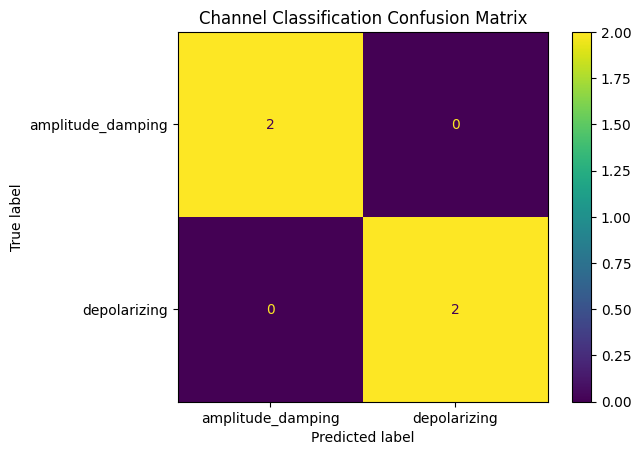

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the true labels for the channels used in Task 5
y_true = [
    'depolarizing',
    'depolarizing',
    'amplitude_damping',
    'amplitude_damping'
]

# 'preds' was generated in the previous cell (-lKtrCIy3kGh)
y_pred = preds

cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Channel Classification Confusion Matrix")
plt.savefig("channel_confusion_matrix.png")
plt.show()

### Submission checklist
- Update `model_path` with the actual artifact you trained in Assignment 3 and note the load result.
- Mention any feature changes you make so the classifier stays compatible with production runs.
- Save this notebook with outputs after running Tasks 1–5 and add a short reflection in your report.